In [5]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

from qiskit.visualization import *
from qiskit_aer import AerSimulator
#from ibm_quantum_widgets import *


from qiskit.quantum_info import SparsePauliOp, commutator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
from qiskit_ibm_runtime import QiskitRuntimeService, Session , EstimatorV2 as Estimator

In [2]:
H_p = SparsePauliOp.from_list(
    [
        ("ZZII", -1.0 ),
        ("IZZI", -1.0 ),
        ("IIZZ", -1.0 ),
        ("ZIII", -0.4 ),
        ("IZII", -0.4 ),
        ("IIZI", -0.4 ),
        ("IIIZ", -0.4 ),
        ("XIII", -0.4 ),
        ("IXII", -0.4 ),
        ("IIXI", -0.4 ),
        ("IIIX", -0.4 )
    ]
)

H_d = SparsePauliOp.from_list(
    [
        ("XIII", 1.0 ),
        ("IXII", 1.0 ),
        ("IIXI", 1.0 ),
        ("IIIX", 1.0 )
    ]
)


# Using H_cd=Y as an example
H_cd = SparsePauliOp.from_list(
    [
        ("YIII", 1.0 ),
        ("IYII", 1.0 ),
        ("IIYI", 1.0 ),
        ("IIIY", 1.0 )
    ]
)


H_random = SparsePauliOp.from_list(
    [
        ("ZIII", 1.0 ),
        ("IZII", 1.0 ),
        ("IIZI", 1.0 ),
        ("IIIZ", 1.0 )
    ]
)

In [7]:
sim_be = AerSimulator(method='density_matrix')

c:\Python\Python312\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


expectation value of commutator:  [-0.0490234375, 3.2894531250000005]
{'rx': 8, 'h': 4, 'rz': 4, 'ry': 4, 'rzz': 3}
energy: -1.883203125
variance: 0.029808547340604886
expectation value of commutator:  [-0.7015625, 4.310742187499999]
{'rx': 16, 'rz': 8, 'ry': 8, 'rzz': 6, 'h': 4}
energy: -2.28173828125
variance: 0.029737132512567814
expectation value of commutator:  [-0.8464843750000001, 5.4556640625]
{'rx': 24, 'rz': 12, 'ry': 12, 'rzz': 9, 'h': 4}
energy: -2.9899414062500003
variance: 0.0289331985924709
expectation value of commutator:  [-1.696484375, 6.122265625000001]
{'rx': 32, 'rz': 16, 'ry': 16, 'rzz': 12, 'h': 4}
energy: -3.7576171875
variance: 0.026503023271322704
expectation value of commutator:  [-1.7839843750000002, 5.435351562499999]
{'rx': 40, 'rz': 20, 'ry': 20, 'rzz': 15, 'h': 4}
energy: -4.362988281250001
variance: 0.02245747917959108
expectation value of commutator:  [-1.1203125000000003, 3.9306640625]
{'rx': 48, 'rz': 24, 'ry': 24, 'rzz': 18, 'h': 4}
energy: -4.60517

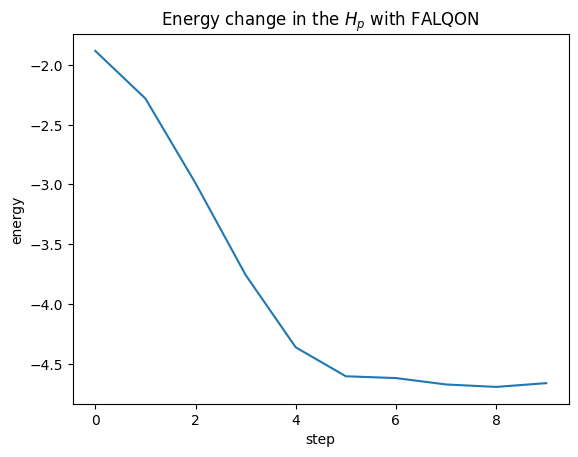

In [13]:
n = 4 # number of qubits
dt = 0.02
depth = 10
backend=sim_be # change to real backend if needed





circuit = QuantumCircuit(n) # |0>|0>...
for j in range(n ):
    circuit.h(j)

    
beta = []
gamma= []
energy_flow = []
meta_flow = []

with Session( backend=backend) as session:
    estimator = Estimator(session=session,options={"resilience_level": 0}) #change "resilience_level" if need error mitigation methods
    for k in range(depth):
        
        commHd = 1.0j*commutator(H_d,H_p)
        commHcd = 1.0j*commutator(H_cd,H_p)

        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuits = pm.run(circuit)
        #isa_observables = hamiltonian.apply_layout(isa_psi.layout)
        
        
        expectation_value_result = estimator.run([(isa_circuits, [commHd.apply_layout(isa_circuits.layout),commHcd.apply_layout(isa_circuits.layout)])]).result()
        [betaExp , gammaExp] = expectation_value_result[0].data.evs
        #print(expectation_value_hd)
        beta.append(-betaExp)
        

        gamma.append(-gammaExp)

        print("expectation value of commutator: ", [betaExp , gammaExp])
        
        
        
        
        for j in range(n-1):    
            circuit.rzz(2*dt,j,j+1)  #exp(-idtZZ/2) since H_p=-Sum(-ZZ-Z-X)

        for j in range(n):    
            circuit.rz(2*dt*0.4,j)  #exp(-idtZZ/2) since H_p=-Sum(-ZZ-Z-X)    
            circuit.rx(2*dt*0.4,j)  #exp(-idtZZ/2) since H_p=-Sum(-ZZ-Z-X)   
            
        
        for j in range(n):
            angle = dt * beta[k]
            circuit.rx(2*angle,j) #drift part with H_d = sum(X)
            
        for j in range(n):
            angle = dt * gamma[k]
            circuit.ry(2*angle,j) #CD part with H_cd = sum(Y)

        print(dict(circuit.count_ops()))
        
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        isa_circuits = pm.run(circuit)
        
        energy_result = estimator.run([(isa_circuits, H_p.apply_layout(isa_circuits.layout))] ).result()
        energy=energy_result[0].data.evs
        meta=energy_result[0].data.stds
        energy_flow.append(energy)
        meta_flow.append(meta)
        
        print("energy:", energy)
        print("variance:", meta)


    
import matplotlib.pyplot as plt

# Generate x-axis values (k values)
k_values = range(len(energy_flow))

# Plotting
plt.plot(k_values, energy_flow)
plt.xlabel('step')
plt.ylabel('energy')
plt.title('Energy change in the $H_p$ with FALQON')

# Display the plot
plt.show()

In [3]:
import qiskit
qiskit.__version__

'1.2.0'